# Get and explore dataset

In [23]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re

In [24]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [25]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [26]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [27]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [28]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

Mean review size:  24.676519799219186
Standard Deviation:  11.28405192884278


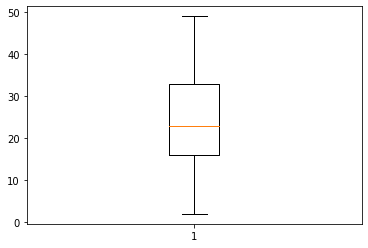

Number of words in the dataset:  7776


In [29]:
# Write some code to investigate the dataset. 
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
# - Calculate the number of words in the dataset
# - Perform any other dataset investigation that you feel would be valuable
review_size = np.array(list(map(len, data)))
print("Mean review size: ", review_size.mean())
print("Standard Deviation: ", review_size.std())
plt.figure()
plt.boxplot(review_size)
plt.show()
plt.close()

numpy_data = np.array(data)
individual_words = np.char.split(numpy_data, ' ')
word_counts = list(map(len, individual_words))
print("Number of words in the dataset: ", np.sum(word_counts))

In [30]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [31]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length
from keras.preprocessing.sequence import pad_sequences
padded_tokenized_data = pad_sequences(tokenized_data, maxlen=25)

In [32]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(padded_tokenized_data, labels, test_size=0.2)

In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, X_test, y_test):
    y_class_test = to_class(y_test)
    y_pred = to_class(model.predict(X_test))
    precision = precision_score(y_class_test, y_pred)
    recall = recall_score(y_class_test, y_pred)
    f1 = f1_score(y_class_test, y_pred)
    print("------------")
    print("Precision : ", precision)
    print("Recall : ", recall)
    print("F1 Score : ", f1)
    print("Confusion Matrix : ", confusion_matrix(y_class_test, y_pred))
    return precision, recall, f1 

# Build and tune model

Define network architecture

In [34]:
from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, BatchNormalization, LSTM, Dense

def build_model(od, b, no_epochs):
    embedding_layer = Embedding(vocab_size, od, input_length=25)
    dropout_layer = SpatialDropout1D(0.2)
    norm_layer = BatchNormalization()
    lstm_layer = LSTM(32)
    output_layer = Dense(2, activation='softmax')
    
    model = Sequential()
    model.add(embedding_layer)
    model.add(dropout_layer)
    model.add(norm_layer)
    model.add(lstm_layer)
    model.add(output_layer)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, batch_size=b, epochs=no_epochs)
    
    return model, history, assess_model(model, X_test, y_test)

Train model

In [35]:
# Compile model and train

output_dim_candidates = [10, 25, 50, 100]
batch_size_candidates = [20, 40, 60]

best_f1 = 0
best_model = None
best_history = None
best_stats = None
best_hyperparams = None
for od in output_dim_candidates:
    for batch_size in batch_size_candidates:
        for epochs in range(50, 52):
            model, history, (precision, recall, f1) = build_model(od, batch_size, epochs)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_history = history
                best_stats = (precision, recall, f1)
                best_hyperparams = (od, batch_size, epochs)
best_outputdim, best_batch_size, best_epochs = best_hyperparams
best_precision, best_recall, best_f1 = best_stats

Epoch 1/50
72/72 [==============================] - 1s 8ms/step - loss: 0.6920 - accuracy: 0.5370
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6683 - accuracy: 0.5802
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6571 - accuracy: 0.5907
Epoch 4/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6456 - accuracy: 0.6234
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6387 - accuracy: 0.6213
Epoch 6/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6446 - accuracy: 0.6130
Epoch 7/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6355 - accuracy: 0.6332
Epoch 8/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6324 - accuracy: 0.6311
Epoch 9/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6291 - accuracy: 0.6276
Epoch 10/50
72/72 [==============================] - 0s 6ms/step - loss: 0.6299 - accuracy: 0.6283
Epoch 11/50
72/72 [

72/72 [==============================] - 0s 6ms/step - loss: 0.5881 - accuracy: 0.6576
Epoch 33/51
72/72 [==============================] - 0s 6ms/step - loss: 0.5871 - accuracy: 0.6653
Epoch 34/51
72/72 [==============================] - 0s 6ms/step - loss: 0.5841 - accuracy: 0.6597
Epoch 35/51
72/72 [==============================] - 0s 6ms/step - loss: 0.5879 - accuracy: 0.6604
Epoch 36/51
72/72 [==============================] - 0s 6ms/step - loss: 0.5822 - accuracy: 0.6520
Epoch 37/51
72/72 [==============================] - 0s 6ms/step - loss: 0.5857 - accuracy: 0.6653
Epoch 38/51
72/72 [==============================] - 1s 8ms/step - loss: 0.5816 - accuracy: 0.6583
Epoch 39/51
72/72 [==============================] - 1s 9ms/step - loss: 0.5726 - accuracy: 0.6702
Epoch 40/51
72/72 [==============================] - 0s 6ms/step - loss: 0.5846 - accuracy: 0.6695
Epoch 41/51
72/72 [==============================] - 0s 6ms/step - loss: 0.5795 - accuracy: 0.6771
Epoch 42/51
72/72 [===

36/36 [==============================] - 0s 7ms/step - loss: 0.6301 - accuracy: 0.6241
Epoch 12/51
36/36 [==============================] - 0s 6ms/step - loss: 0.6265 - accuracy: 0.6276
Epoch 13/51
36/36 [==============================] - 0s 7ms/step - loss: 0.6302 - accuracy: 0.6381
Epoch 14/51
36/36 [==============================] - 0s 7ms/step - loss: 0.6195 - accuracy: 0.6311
Epoch 15/51
36/36 [==============================] - 0s 7ms/step - loss: 0.6239 - accuracy: 0.6367
Epoch 16/51
36/36 [==============================] - 0s 7ms/step - loss: 0.6198 - accuracy: 0.6395
Epoch 17/51
36/36 [==============================] - 0s 6ms/step - loss: 0.6155 - accuracy: 0.6332
Epoch 18/51
36/36 [==============================] - 0s 6ms/step - loss: 0.6186 - accuracy: 0.6311
Epoch 19/51
36/36 [==============================] - 0s 6ms/step - loss: 0.6126 - accuracy: 0.6485
Epoch 20/51
36/36 [==============================] - 0s 6ms/step - loss: 0.6115 - accuracy: 0.6402
Epoch 21/51
36/36 [===

24/24 [==============================] - 0s 6ms/step - loss: 0.5927 - accuracy: 0.6583
Epoch 42/50
24/24 [==============================] - 0s 5ms/step - loss: 0.5894 - accuracy: 0.6604
Epoch 43/50
24/24 [==============================] - 0s 6ms/step - loss: 0.5979 - accuracy: 0.6513
Epoch 44/50
24/24 [==============================] - 0s 5ms/step - loss: 0.5836 - accuracy: 0.6639
Epoch 45/50
24/24 [==============================] - 0s 7ms/step - loss: 0.5807 - accuracy: 0.6702
Epoch 46/50
24/24 [==============================] - 0s 6ms/step - loss: 0.5836 - accuracy: 0.6562
Epoch 47/50
24/24 [==============================] - 0s 8ms/step - loss: 0.5874 - accuracy: 0.6513
Epoch 48/50
24/24 [==============================] - 0s 7ms/step - loss: 0.5875 - accuracy: 0.6513
Epoch 49/50
24/24 [==============================] - 0s 7ms/step - loss: 0.5823 - accuracy: 0.6646
Epoch 50/50
24/24 [==============================] - 0s 6ms/step - loss: 0.5791 - accuracy: 0.6702
------------
Precision

72/72 [==============================] - 0s 7ms/step - loss: 0.6017 - accuracy: 0.6506
Epoch 21/50
72/72 [==============================] - 0s 6ms/step - loss: 0.5954 - accuracy: 0.6569
Epoch 22/50
72/72 [==============================] - 0s 6ms/step - loss: 0.5906 - accuracy: 0.6437
Epoch 23/50
72/72 [==============================] - 0s 6ms/step - loss: 0.5946 - accuracy: 0.6527
Epoch 24/50
72/72 [==============================] - 0s 7ms/step - loss: 0.5917 - accuracy: 0.6681
Epoch 25/50
72/72 [==============================] - 0s 7ms/step - loss: 0.5879 - accuracy: 0.6639
Epoch 26/50
72/72 [==============================] - 0s 7ms/step - loss: 0.5882 - accuracy: 0.6492
Epoch 27/50
72/72 [==============================] - 0s 7ms/step - loss: 0.5849 - accuracy: 0.6590
Epoch 28/50
72/72 [==============================] - 0s 6ms/step - loss: 0.5826 - accuracy: 0.6541
Epoch 29/50
72/72 [==============================] - 0s 7ms/step - loss: 0.5803 - accuracy: 0.6667
Epoch 30/50
72/72 [===

72/72 [==============================] - 0s 7ms/step - loss: 0.5503 - accuracy: 0.6869
------------
Precision :  0.5776892430278885
Recall :  0.7923497267759563
F1 Score :  0.6682027649769585
Confusion Matrix :  [[ 70 106]
 [ 38 145]]
Epoch 1/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6886 - accuracy: 0.5397
Epoch 2/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6614 - accuracy: 0.5948
Epoch 3/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6504 - accuracy: 0.6116
Epoch 4/50
36/36 [==============================] - 0s 7ms/step - loss: 0.6494 - accuracy: 0.6060
Epoch 5/50
36/36 [==============================] - 0s 7ms/step - loss: 0.6442 - accuracy: 0.6067
Epoch 6/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6409 - accuracy: 0.6318
Epoch 7/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6339 - accuracy: 0.6304
Epoch 8/50
36/36 [==============================] - 0s 7ms/step - loss: 0.6312 

36/36 [==============================] - 0s 10ms/step - loss: 0.5923 - accuracy: 0.6548
Epoch 30/51
36/36 [==============================] - 0s 8ms/step - loss: 0.5813 - accuracy: 0.6674
Epoch 31/51
36/36 [==============================] - 0s 9ms/step - loss: 0.5804 - accuracy: 0.6625
Epoch 32/51
36/36 [==============================] - 0s 11ms/step - loss: 0.5803 - accuracy: 0.6709
Epoch 33/51
36/36 [==============================] - 0s 10ms/step - loss: 0.5782 - accuracy: 0.6834
Epoch 34/51
36/36 [==============================] - 0s 11ms/step - loss: 0.5742 - accuracy: 0.6764
Epoch 35/51
36/36 [==============================] - 0s 8ms/step - loss: 0.5752 - accuracy: 0.6750
Epoch 36/51
36/36 [==============================] - 0s 12ms/step - loss: 0.5739 - accuracy: 0.6785
Epoch 37/51
36/36 [==============================] - 1s 19ms/step - loss: 0.5717 - accuracy: 0.6736
Epoch 38/51
36/36 [==============================] - 0s 9ms/step - loss: 0.5720 - accuracy: 0.6757
Epoch 39/51
36/3

24/24 [==============================] - 0s 9ms/step - loss: 0.6403 - accuracy: 0.6269
Epoch 8/51
24/24 [==============================] - 0s 9ms/step - loss: 0.6324 - accuracy: 0.6353
Epoch 9/51
24/24 [==============================] - 0s 9ms/step - loss: 0.6300 - accuracy: 0.6283
Epoch 10/51
24/24 [==============================] - 0s 8ms/step - loss: 0.6274 - accuracy: 0.6297
Epoch 11/51
24/24 [==============================] - 0s 9ms/step - loss: 0.6272 - accuracy: 0.6402
Epoch 12/51
24/24 [==============================] - 0s 9ms/step - loss: 0.6270 - accuracy: 0.6346
Epoch 13/51
24/24 [==============================] - 0s 8ms/step - loss: 0.6230 - accuracy: 0.6269
Epoch 14/51
24/24 [==============================] - 0s 9ms/step - loss: 0.6170 - accuracy: 0.6444
Epoch 15/51
24/24 [==============================] - 0s 9ms/step - loss: 0.6181 - accuracy: 0.6353
Epoch 16/51
24/24 [==============================] - 0s 8ms/step - loss: 0.6164 - accuracy: 0.6471
Epoch 17/51
24/24 [=====

72/72 [==============================] - 1s 8ms/step - loss: 0.5573 - accuracy: 0.6862
Epoch 38/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5571 - accuracy: 0.6827
Epoch 39/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5500 - accuracy: 0.6792
Epoch 40/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5500 - accuracy: 0.6946
Epoch 41/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5526 - accuracy: 0.6883
Epoch 42/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5473 - accuracy: 0.6778
Epoch 43/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5476 - accuracy: 0.6918
Epoch 44/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5553 - accuracy: 0.6729
Epoch 45/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5477 - accuracy: 0.6876
Epoch 46/50
72/72 [==============================] - 1s 8ms/step - loss: 0.5428 - accuracy: 0.7001
Epoch 47/50
72/72 [===

36/36 [==============================] - 0s 9ms/step - loss: 0.6095 - accuracy: 0.6374
Epoch 17/50
36/36 [==============================] - 0s 9ms/step - loss: 0.6012 - accuracy: 0.6450
Epoch 18/50
36/36 [==============================] - 0s 9ms/step - loss: 0.6003 - accuracy: 0.6506
Epoch 19/50
36/36 [==============================] - 0s 9ms/step - loss: 0.5992 - accuracy: 0.6548
Epoch 20/50
36/36 [==============================] - 0s 9ms/step - loss: 0.5976 - accuracy: 0.6534
Epoch 21/50
36/36 [==============================] - 0s 9ms/step - loss: 0.5919 - accuracy: 0.6590
Epoch 22/50
36/36 [==============================] - 0s 9ms/step - loss: 0.5909 - accuracy: 0.6604
Epoch 23/50
36/36 [==============================] - 0s 9ms/step - loss: 0.5921 - accuracy: 0.6604
Epoch 24/50
36/36 [==============================] - 0s 10ms/step - loss: 0.5884 - accuracy: 0.6562
Epoch 25/50
36/36 [==============================] - 0s 9ms/step - loss: 0.5938 - accuracy: 0.6611
Epoch 26/50
36/36 [==

36/36 [==============================] - 0s 10ms/step - loss: 0.5544 - accuracy: 0.6848
Epoch 48/51
36/36 [==============================] - 0s 9ms/step - loss: 0.5580 - accuracy: 0.6862
Epoch 49/51
36/36 [==============================] - 0s 9ms/step - loss: 0.5481 - accuracy: 0.6897
Epoch 50/51
36/36 [==============================] - 0s 10ms/step - loss: 0.5461 - accuracy: 0.6918
Epoch 51/51
36/36 [==============================] - 0s 9ms/step - loss: 0.5546 - accuracy: 0.6806
------------
Precision :  0.5805084745762712
Recall :  0.7486338797814208
F1 Score :  0.6539379474940333
Confusion Matrix :  [[ 77  99]
 [ 46 137]]
Epoch 1/50
24/24 [==============================] - 0s 11ms/step - loss: 0.7159 - accuracy: 0.5098
Epoch 2/50
24/24 [==============================] - 0s 11ms/step - loss: 0.6760 - accuracy: 0.5614
Epoch 3/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6552 - accuracy: 0.5990
Epoch 4/50
24/24 [==============================] - 0s 10ms/step - los

24/24 [==============================] - 0s 10ms/step - loss: 0.5910 - accuracy: 0.6541
Epoch 26/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5903 - accuracy: 0.6597
Epoch 27/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5913 - accuracy: 0.6625
Epoch 28/51
24/24 [==============================] - 0s 11ms/step - loss: 0.5858 - accuracy: 0.6667
Epoch 29/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5780 - accuracy: 0.6764
Epoch 30/51
24/24 [==============================] - 0s 11ms/step - loss: 0.5848 - accuracy: 0.6695
Epoch 31/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5831 - accuracy: 0.6632
Epoch 32/51
24/24 [==============================] - 0s 11ms/step - loss: 0.5794 - accuracy: 0.6702
Epoch 33/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5721 - accuracy: 0.6722
Epoch 34/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5755 - accuracy: 0.6688
Epoch 35/51


72/72 [==============================] - 1s 11ms/step - loss: 0.6553 - accuracy: 0.5816
Epoch 4/51
72/72 [==============================] - 1s 11ms/step - loss: 0.6434 - accuracy: 0.6144
Epoch 5/51
72/72 [==============================] - 1s 10ms/step - loss: 0.6330 - accuracy: 0.6185
Epoch 6/51
72/72 [==============================] - 1s 11ms/step - loss: 0.6263 - accuracy: 0.6318
Epoch 7/51
72/72 [==============================] - 1s 11ms/step - loss: 0.6176 - accuracy: 0.6409
Epoch 8/51
72/72 [==============================] - 1s 11ms/step - loss: 0.6206 - accuracy: 0.6437
Epoch 9/51
72/72 [==============================] - 1s 10ms/step - loss: 0.6184 - accuracy: 0.6325
Epoch 10/51
72/72 [==============================] - 1s 11ms/step - loss: 0.6125 - accuracy: 0.6332
Epoch 11/51
72/72 [==============================] - 1s 10ms/step - loss: 0.6067 - accuracy: 0.6402
Epoch 12/51
72/72 [==============================] - 1s 11ms/step - loss: 0.6074 - accuracy: 0.6423
Epoch 13/51
72/72 

36/36 [==============================] - 0s 12ms/step - loss: 0.5642 - accuracy: 0.6709
Epoch 33/50
36/36 [==============================] - 0s 12ms/step - loss: 0.5628 - accuracy: 0.6813
Epoch 34/50
36/36 [==============================] - 0s 13ms/step - loss: 0.5624 - accuracy: 0.6827
Epoch 35/50
36/36 [==============================] - 0s 12ms/step - loss: 0.5622 - accuracy: 0.6785
Epoch 36/50
36/36 [==============================] - 0s 12ms/step - loss: 0.5545 - accuracy: 0.6974
Epoch 37/50
36/36 [==============================] - 0s 13ms/step - loss: 0.5543 - accuracy: 0.6897
Epoch 38/50
36/36 [==============================] - 0s 12ms/step - loss: 0.5523 - accuracy: 0.6848
Epoch 39/50
36/36 [==============================] - 0s 13ms/step - loss: 0.5566 - accuracy: 0.6911
Epoch 40/50
36/36 [==============================] - 0s 12ms/step - loss: 0.5505 - accuracy: 0.7001
Epoch 41/50
36/36 [==============================] - 0s 13ms/step - loss: 0.5503 - accuracy: 0.6862
Epoch 42/50


24/24 [==============================] - 0s 15ms/step - loss: 0.6218 - accuracy: 0.6360
Epoch 11/50
24/24 [==============================] - 0s 14ms/step - loss: 0.6191 - accuracy: 0.6234
Epoch 12/50
24/24 [==============================] - 0s 15ms/step - loss: 0.6118 - accuracy: 0.6457
Epoch 13/50
24/24 [==============================] - 0s 14ms/step - loss: 0.6074 - accuracy: 0.6416
Epoch 14/50
24/24 [==============================] - 0s 14ms/step - loss: 0.6061 - accuracy: 0.6444
Epoch 15/50
24/24 [==============================] - 0s 14ms/step - loss: 0.6045 - accuracy: 0.6506
Epoch 16/50
24/24 [==============================] - 0s 14ms/step - loss: 0.6008 - accuracy: 0.6450
Epoch 17/50
24/24 [==============================] - 0s 15ms/step - loss: 0.6070 - accuracy: 0.6430
Epoch 18/50
24/24 [==============================] - 0s 16ms/step - loss: 0.5941 - accuracy: 0.6576
Epoch 19/50
24/24 [==============================] - 0s 15ms/step - loss: 0.5968 - accuracy: 0.6541
Epoch 20/50


24/24 [==============================] - 0s 11ms/step - loss: 0.5661 - accuracy: 0.6820
Epoch 41/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5654 - accuracy: 0.6792
Epoch 42/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5639 - accuracy: 0.6876
Epoch 43/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5599 - accuracy: 0.6869
Epoch 44/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5553 - accuracy: 0.6876
Epoch 45/51
24/24 [==============================] - 0s 11ms/step - loss: 0.5631 - accuracy: 0.6806
Epoch 46/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5570 - accuracy: 0.6911
Epoch 47/51
24/24 [==============================] - 0s 11ms/step - loss: 0.5572 - accuracy: 0.6827
Epoch 48/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5516 - accuracy: 0.6813
Epoch 49/51
24/24 [==============================] - 0s 10ms/step - loss: 0.5542 - accuracy: 0.6764
Epoch 50/51


Examine performance of model

In [36]:
print("Best Hyperparameters:")
print("output_dim: ", best_outputdim)
print("batch_size: ", best_batch_size)
print("# epochs: ", best_epochs)
print("Best stats: ")
print("precision: ", best_precision)
print("recall: ", best_recall)
print("f1 score: ", best_f1)

Best Hyperparameters:
output_dim:  50
batch_size:  20
# epochs:  50
Best stats: 
precision:  0.5747126436781609
recall:  0.819672131147541
f1 score:  0.6756756756756757


Plot graphs for accuracy and loss

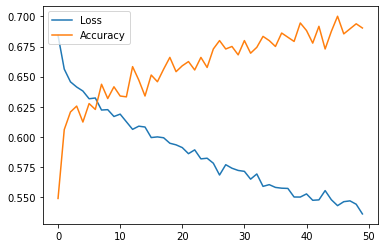

In [37]:
plt.figure()
plt.plot(best_history.history['loss'], label='Loss')
plt.plot(best_history.history['accuracy'], label='Accuracy')
plt.legend(loc='upper left')
plt.show()
plt.close()

# Make a prediction

In [38]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post', maxlen=25)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.
y_pred = to_word_label(best_model.predict(padded))
for i in range(len(y_pred)):
    print(prediction_data[i], " : ", y_pred[i])

this book is fabulous  :  negative
i hated this book  :  negative
the best  :  negative
no good  :  negative
okay  :  negative
